[54 循环神经网络 RNN](https://www.bilibili.com/video/BV1D64y1z7CA?spm_id_from=333.999.0.0)
- <img src="picture/屏幕截图 2022-05-31 191341.png">
- 新概念h：隐变量，这个变量是真实存在的，但无法被感知到的变量
- 输出$o_t只能由隐变量h_t和x_{t-1}共同进行输出，不能由x_t直接输出$
- $h_t = \phi(W_{hh}h_{t-1}+W_{}{hx}X_{t-1}+b_h)$
- $o_t = \phi(W_{oh}+b_o)这里视频有误是W_{oh}$
- <img src="picture/屏幕截图 2022-05-31 191542.png">
- 输出$o_t是作为当前时刻的预测值，预测x_t的值$
- <img src="picture/屏幕截图 2022-05-31 193028.png">

- 困惑度 perplexity
- 衡量一个模型的好坏可以用平均交叉熵来衡量
- $$\pi = \frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)$$
- p是语言模型的预测概率，$x_t$是真实词
- 历史原因NLP使用$exp(\pi)$来衡量（能够扩大相应的值，直接使用会太小）
- 1表示完美。无穷大是最差情况

- <img src="picture/屏幕截图 2022-05-31 230201.png">
- 主要应用
- <img src="picture/屏幕截图 2022-05-31 231212.png">

[55 循环神经网络 RNN 的实现](https://www.bilibili.com/video/BV1kq4y1H7sw/?spm_id_from=333.788.recommend_more_video.1)

In [1]:
# 开炼！
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

/opt/conda/envs/ml/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/envs/ml/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 加载数据集
# vocab
batch_size,num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [3]:
for x in train_iter:
    print(x[0].shape)
    print(x[0][0])
    print(x[1].shape)
    print(x[1][0])
    break

torch.Size([32, 35])
tensor([18,  1, 17,  2, 12, 12,  8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3,
        10,  4, 22,  2, 12, 12,  2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5])
torch.Size([32, 35])
tensor([ 1, 17,  2, 12, 12,  8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3, 10,
         4, 22,  2, 12, 12,  2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5,  3])


In [4]:
vocab.token_freqs

[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674),
 ('d', 6337),
 ('l', 6146),
 ('m', 4043),
 ('u', 3805),
 ('c', 3424),
 ('f', 3354),
 ('w', 3225),
 ('g', 3075),
 ('y', 2679),
 ('p', 2427),
 ('b', 1897),
 ('v', 1295),
 ('k', 1087),
 ('x', 236),
 ('z', 144),
 ('j', 97),
 ('q', 95)]

In [5]:
len(vocab)

28

In [6]:
# 独热编码
F.one_hot(torch.tensor([0,2,12]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [7]:
# 小批量数据的形状是（批量大小,时间步数）
# rnn的时间步长可以理解为tau，也是错位的序列
# 由于文本是连续的，时间步长在文本上就表现为单词的连续，例如时间步数为5，就表示5元组成一个序列
# 批量大小指的是多少个序列组成一组
X = torch.arange(10).reshape(2,5)
F.one_hot(X.T,28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

- $h_t = \phi(W_{hh}h_{t-1}+W_{}{hx}X_{t-1}+b_h)$
- $o_t = \phi(W_{oh}+b_o)$

In [8]:
# 初始化参数模型
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_hh = normal((num_hiddens, num_hiddens))
    W_xh = normal((num_inputs, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [9]:
# init_run_state函数在初始化时候返回隐藏状态
# 0时刻是没有隐藏状态的，所以需要给一个最初始的状态用于启动
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

- $h_t = \phi(W_{hh}h_{t-1}+W_{}{hx}X_{t-1}+b_h)$
- $o_t = \phi(W_{oh}+b_o)$

In [10]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 这里现在只有一组隐藏层，后面隐藏层不止一层的时候可以进行扩充
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    # 矩阵相乘有torch.mm和torch.matmul两个函数。其中前一个是针对二维矩阵，后一个是高维。当torch.mm用于大于二维时将报错。
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
        # 这里输出变成了列数为len(vocab),列数变成了batch_size*时间步长
        # 后面能看到，这是为了计算loss需要
    # 与前馈神经网络相比，多返回了一个H隐藏层参数
    return torch.cat(outputs, dim=0), (H,)
    

In [11]:
class RNNModelScratch: 
    """从零开始实现的循环神经网络模型"""
    """vocab size:词典大小，num_hiddens：隐藏层数，"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        # 生成初始化参数
        self.params = get_params(vocab_size, num_hiddens, device)
        # 分配0时刻参数，forward_fn：导入模型
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # 将输入数据进行独热编码
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    # 程序开始前，需要给隐藏层赋予初试值
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [12]:
# 输入检测
num_hiddens = 512
net = RNNModelScratch(
    len(vocab), # vocab_size
    num_hiddens, 
    d2l.try_gpu(),
    get_params, 
    init_rnn_state, # init_state
    rnn 
)
# state就是隐藏层整体
state = net.begin_state(X.shape[0],d2l.try_gpu())
"""
代入进行计算
net()相当于net.__call__ , 这里就是
rnn(X.to(d2l.try_gpu(), 
    state, 
    get_params(vocab_size, num_hiddens, device)
    )
"""
Y,new_state = net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [13]:
# 定义预测函数
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串
        prefix :给一段句子作为开头，并以此为开头不断循环生成句子
        num_preds ：需要生成多少个词
    """
    # 初试隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    # 输出每个字符在vocab中的下标
    outputs = [vocab[prefix[0]]]
    # 上一个最后预测的结果会作为下一个输入值
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    """循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，
    但是不生成任何输出。 这被称为预热（warm-up）期， 
    在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。 
    预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。
    """
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [14]:
predict_ch8('time traveller ', 30, net, vocab, d2l.try_gpu())

'time traveller tftftftftftftftftftftftftftftf'

对于长度为(T)的序列，我们在迭代中计算这(T)个时间步上的梯度， 将会在反向传播过程中产生长度为$(\mathcal{O}(T))$的矩阵乘法链。 如 4.8节所述， 当(T)较大时，它可能导致数值不稳定， 例如可能导致梯度爆炸或梯度消失。 因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤。 假定在向量形式的$(\mathbf{x})$中， 或者在小批量数据的负梯度$(\mathbf{g})$方向上。 例如，使用$(\eta > 0)$作为学习率时，在一次迭代中， 我们将$(\mathbf{x})$更新为
$(\mathbf{x} - \eta \mathbf{g})$。 如果我们进一步假设目标函数(f)表现良好， 即函数(f)在常数(L)下是利普希茨连续的（Lipschitz continuous）。 也就是说，对于任意$(\mathbf{x})和(\mathbf{y})$我们有：

(8.5.1)$[|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.]$
在这种情况下，我们可以安全地假设： 如果我们通过$(\eta \mathbf{g})$更新参数向量，则

(8.5.2)$[|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,]$
这意味着我们不会观察到超过$(L \eta \|\mathbf{g}\|)$的变化。 这既是坏事也是好事。 坏的方面，它限制了取得进展的速度； 好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。 我们可以通过降低$(\eta)$的学习率来解决这个问题。 但是如果我们很少得到大的梯度呢？ 在这种情况下，这种做法似乎毫无道理。 一个流行的替代方案是通过将梯度$(\mathbf{g})$投影回给定半径 （例如$(\theta)$）的球来裁剪梯度$(\mathbf{g})$。 如下式：

(8.5.3)$[\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.]$
通过这样做，我们知道梯度范数永远不会超过$(\theta)$， 并且更新后的梯度完全与$(\mathbf{g})$的原始方向对齐。 它还有一个值得拥有的副作用， 即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响， 这赋予了模型一定程度的稳定性。 梯度裁剪提供了一个快速修复梯度爆炸的方法， 虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度， 模型是从零开始实现的模型或由高级API构建的模型。 我们在此计算了所有模型参数的梯度的范数。

In [15]:
def grad_clipping(net, theta):  
    """裁剪梯度
    其实就是可以想象成n个循环就是n个带隐藏层的MLP相乘，没处理好肯定会梯度爆炸，所以需要进行裁剪
    裁剪方法就是8.5.3
    """
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 所有层的梯度全部求和
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            # 修改全部层
            param.grad[:] *= theta / norm

In [16]:
# 训练函数，这里的训练是一个epoch内，不是一个batch
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）
    
    use_random_iter：下一个训练样本是否是接着上一个训练样本
    """
    # 这里先定义一个空的state隐藏层
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            """
            在第一次迭代或使用随机抽样时初始化state
            这里为什么要循环判断，而不是直接把初始化放在循环外面呢
            因为上一个批量如果和当前批量不连续的话，那么之前的初始值是不可以用的。
            """
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 类似于flatten操作  
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        # 网络会同时返回预测结果和隐藏层
        y_hat, state = net(X, state)
        # 这里可以看出为什么每个batch需要append
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # 梯度裁剪
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # 这里math.exp(metric[0] / metric[1])返回的是困惑度
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


- 如果我们有两个网络 A,B, 两个关系是这样的 y=A(x),  z=B(y)
- 现在我们想用 z.backward() 来为 B 网络的参数来求梯度，
- 但是又不想求 A 网络参数的梯度。我们可以这样：



```
# y=A(x), z=B(y) 求B中参数的梯度，不求A中参数的梯度
# 第一种方法
y = A(x)
z = B(y.detach())
z.backward()

# 第二种方法
y = A(x)
y.detach_()
z = B(y)
z.backward()
```

In [17]:
# torch.long():向下取整
b1 = torch.rand(3,3)*10
print(b1)
b1.long()

tensor([[8.6382, 8.4621, 6.3117],
        [2.1812, 4.3212, 4.2091],
        [4.2661, 5.6798, 3.5156]])


tensor([[8, 8, 6],
        [2, 4, 4],
        [4, 5, 3]])

In [18]:
# 开始训练
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller '))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 119706.7 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


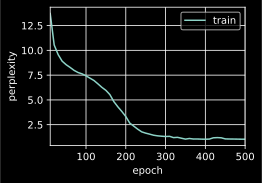

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 120857.4 词元/秒 cuda:0
time traveller proceeded anyreal body must have extension in fou
traveller after the pauserequired for the proper assimilati


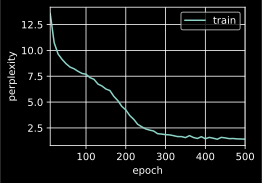

In [20]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)